# Comparing different types of MMD regarding runtime and variance

Necessary imports:

In [34]:
import numpy as np
import numpy.linalg as la
import time
import math
import matplotlib.pyplot as plt
import random
from mmdew.bucket_stream_old import BucketStream
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances
from scipy.stats import norm
from sklearn import metrics

We will take a look at Nyström MMD, biased MMD and Linear Time MMD.
Define the functions first:

In [35]:
def biased_mmd(X, Y, m_magnitude=None):
    XX = rbf_kernel(X, X)
    YY = rbf_kernel(Y, Y)
    XY = rbf_kernel(X, Y)
    
    return XX.mean() + YY.mean() - 2 * XY.mean()


def unbiased_mmd(X, Y):
    n = len(X)
    m = len(Y)
    
    XX = rbf_kernel(X, X)
    YY = rbf_kernel(Y, Y)
    XY = rbf_kernel(X, Y)
    
    np.fill_diagonal(XX, 0)
    np.fill_diagonal(YY, 0)
    
    return 1 / (n * (n - 1)) * np.sum(XX) + 1 / (m * (m - 1)) * np.sum(YY) - 2 / (n * m) * np.sum(XY)


def nystroem_mmd(X, Y, m):
    n = len(X)
    #m = int(m_magnitude(n))
    m_idx = np.random.default_rng().integers(n, size=m)
    X_tilde = X[m_idx]
    Y_tilde = Y[m_idx]
    
    XX = rbf_kernel(X_tilde, X_tilde)
    YY = rbf_kernel(Y_tilde, Y_tilde)
    XY = rbf_kernel(X_tilde, Y_tilde)
    
    X_mn = rbf_kernel(X_tilde, X)
    Y_mn = rbf_kernel(Y_tilde, Y)
    
    alpha_1 = 1 / n * la.pinv(XX) @ X_mn @ np.ones((n, 1))
    alpha_2 = 1 / n * la.pinv(YY) @ Y_mn @ np.ones((n, 1))
    return (alpha_1.T @ XX @ alpha_1 + alpha_2.T @ YY @ alpha_2 - 2 * alpha_1.T @ XY @ alpha_2)[0][0]

### First, run Biased- and Nyström-MMD in a simple environment to observe first results.

In [3]:
n = 2000
np.random.seed(1234)
X = np.random.randn(n, 1)
Y = np.random.randn(n, 1)

start = time.time()
biased_result = biased_mmd(X, Y)
end = time.time()
biased_mmd_runtime = "{:.4f}".format(end - start)

start = time.time()
unbiased_result = unbiased_mmd(X, Y)
end = time.time()
unbiased_mmd_runtime = "{:.4f}".format(end - start)

start = time.time()
#nystroem_result = nystroem_mmd(X, Y, m_magnitude=(lambda x: np.sqrt(x)))
nystroem_result = nystroem_mmd(X, Y, int(np.sqrt(n)))
end = time.time()
nystroem_mmd_runtime = "{:.4f}".format(end - start)

print(f"Biased:  {biased_result}, runtime: {biased_mmd_runtime}s")
print(f"Unbiased: {unbiased_result}, runtime: {unbiased_mmd_runtime}s")
print(f"Nyström: {nystroem_result}, runtime: {nystroem_mmd_runtime}s")

Biased:  0.0005290304550864544, runtime: 0.0801s
Unbiased: -1.852557440940039e-05, runtime: 0.0716s
Nyström: 0.0005358060777638229, runtime: 0.0115s


We also take the runtime of Biased-MMD as baseline.

### Now, plot the runtime of Nyström-MMD mapped to subsample-size $m$ depending on $n = 10000$

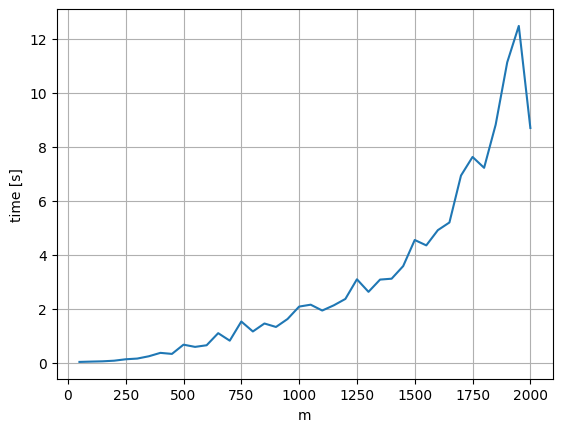

Total time: 120.324791431427s


In [4]:
n = 10000
np.random.seed(1234)
#ms = [lambda x: np.log(x), lambda x: math.pow(x, 0.25),
#      lambda x: x / 100, lambda x: np.sqrt(x), lambda x: x / 10, lambda x: x / 5]

ms = list(range(50, 2050, 50))
runtimes = []

for m in ms:
    X = np.random.randn(n, 1)
    Y = np.random.randn(n, 1)
    start = time.time()
    # discard the return value
    nystroem_mmd(X, Y, m)
    end = time.time()
    current_runtime = end - start
    runtimes.append(current_runtime)

plt.plot(ms, runtimes)
plt.xlabel("m")
plt.ylabel("time [s]")
plt.grid(True)
plt.show()

print(f"Total time: {sum(runtimes)}s")

### In this section, we will evaluate how well Nyström-MMD does with $X$ and $Y$ being sampled from different distributions. Note that $|X| = |Y| = n = 10000$

First, draw both samples from the standard normal distribution and verify, that the return value is approximatively 0

In [5]:
n = 20000
X = np.random.randn(n, 1)
Y = np.random.randn(n, 1)
nystroem_mmd(X, Y, m=math.ceil(np.sqrt(n)))

0.000164008818175021

From now, $X$ is standard normally distributed, whereas $Y$ is drawn from a different distribution

In [6]:
X = np.random.randn(n, 1)
Y = np.random.poisson(size=(n, 1))
result = nystroem_mmd(X, Y, int(np.sqrt(n)))
print(f"For Y ~ Poisson: {result}")

X = np.random.randn(n, 1)
n_binom, p = 5, 0.4
Y = np.random.binomial(n=n_binom, p=p, size=(n, 1))
result = nystroem_mmd(X, Y,int(np.sqrt(n)))
print(f"For Y ~ Binomial: {result} where n={n_binom} and p={p}")

X = np.random.randn(n, 1)
Y = np.random.chisquare(df=2, size=(n, 1))
result = nystroem_mmd(X, Y, int(np.sqrt(n)))
print(f"For Y ~ Chi-Square: {result} where degree of freedom is 5")

For Y ~ Poisson: 0.1252507370241015
For Y ~ Binomial: 0.4331638220077171 where n=5 and p=0.4
For Y ~ Chi-Square: 0.21115286504495723 where degree of freedom is 5


### This section will evaluate the variance of different estimators, including Nyström-MMD-estimators with different values for $m$. Let $k$ be the number of iterations for computing the variance. $n$ is the size of the samples, that are drawn from the standard normal distribution.

For additional purposes, the Linear Time Test (Gretton: A Kernel Two-Sample Test) and the B-Test (B-tests: Low Variance Kernel Two-Sample Tests, Zaremba) are implemented here

In [36]:
def ltt(X, Y):
    m = len(X)
    m2 = math.floor(m / 2)
    
    total = 0
    for i in range(1, m2):
        total += _h(X[2 * i - 1], Y[2 * i - 1], X[2 * i], Y[2 * i])
    return total / m2

def _h(x_i, y_i, x_j, y_j):
    return squared_euclidean_kernel(x_i, x_j) + squared_euclidean_kernel(y_i, y_j) - squared_euclidean_kernel(x_i, y_j) - squared_euclidean_kernel(x_j, y_i)

# rbf-kernel with scalar input
def squared_euclidean_kernel(x, y, gamma=None):
    if gamma is None:
        # n_features = 1
        gamma = 1.0
    return math.exp(-gamma * abs(x - y) ** 2)

In [37]:
def b_test(X, Y, B):
    n = len(X)
    number_of_blocks = int((n / B))
    X_blocks = np.array_split(X, number_of_blocks)
    Y_blocks = np.array_split(Y, number_of_blocks)
    block_mmds = np.zeros(number_of_blocks)
    for i in range(number_of_blocks):
        block_mmds[i] = unbiased_mmd(X_blocks[i], Y_blocks[i])
    return block_mmds.mean()

In [38]:
n = 2000000
X = np.random.randn(n, 1)
Y = np.random.randn(n, 1)
ltt(X, Y)

KeyboardInterrupt: 

In [10]:
n = 26400
X = np.random.randn(n, 1)
Y = np.random.randn(n, 1)
b_test(X, Y, 2)

-0.004992748715319911

Also, MMDAW (Kalinke: Scalable Online Change Detection for High-dimensional Data Streams) is evaluated here.

**Important: For given $k$, $X$ and $Y$ must be of following sizes: $n := |X| = 2^{k - 1}$ and $m := |Y| = 2^{k - 1} - 1$**

In [39]:
# k > 1
def run_mmdaw(k):
    assert k > 1
    n = 2 ** (k - 1)
    m = 2 ** (k - 1) - 1

    X = np.random.randn(n, 1)
    Y = np.random.randn(m, 1)
    
    mmdaw_estimator = BucketStream(gamma=1)
    for x in X:
        mmdaw_estimator.insert(x)
    for y in Y:
        mmdaw_estimator.insert(y)
    mmd_value, end, start = mmdaw_estimator.mmd(split=1)
    return mmd_value

In [12]:
run_mmdaw(k=9)

0.012248834614378978

Unbiased MMD: took 14.00343918800354s
Biased MMD: took 13.780812978744507s
B-test: B = sqrt(n): took 3.0819010734558105s
Nyström: m = sqrt(n): took 1.4719128608703613s


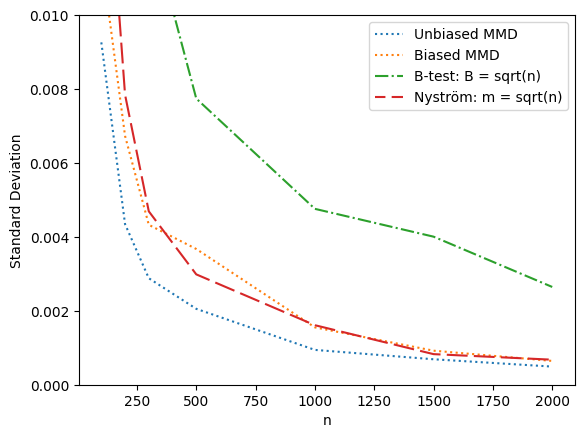

In [29]:
regular_scale = [100, 200, 300, 500, 1000, 1500, 2000]
mmdaw_scale = [6, 7, 8, 9, 10, 11, 12]
iterations = 100

estimators = [
             (unbiased_mmd, None, regular_scale, "Unbiased MMD", "dotted"),
             #(ltt, None, regular_scale, "Linear Time Test", "dashed"),
             (biased_mmd, None, regular_scale, "Biased MMD", "dotted"),
             (b_test, lambda x: np.sqrt(x), regular_scale, "B-test: B = sqrt(n)", "dashdot"),
             (nystroem_mmd, lambda x: np.sqrt(x), regular_scale, "Nyström: m = sqrt(n)", (5, (10, 3))),
             #(nystroem_mmd, lambda x: np.log(x), regular_scale, "Nyström: m = log(n)", (0, (3, 1, 1, 1, 1, 1))),
             #(run_mmdaw, None, mmdaw_scale, "MMDAW", "solid")
            ]



for (estimator, magnitude, scale, label, linestyle) in estimators:
    start = time.time()
    vs = []  
    for n_value in scale:
        variance = 0
        for i in range(0, iterations):
            if estimator is run_mmdaw:
                variance += run_mmdaw(n_value)
                continue
            X = np.random.randn(n_value, 1)
            Y = np.random.randn(n_value, 1)
            if magnitude is not None:
                variance += estimator(X, Y, int(magnitude(n_value))) ** 2
            else:
                variance += estimator(X, Y) ** 2
        vs.append(np.sqrt(variance / iterations))
    plt.plot(regular_scale, vs, label=label, linestyle=linestyle)
    plt.xlabel("n")
    plt.ylabel("Standard Deviation")
    end = time.time()
    print(f"{label}: took {end - start}s")
plt.ylim(0,.01)
plt.legend(loc="upper right")
plt.savefig('mmd-estimators_mmdaw.pdf')
plt.show()    


In [41]:
def k(x,y,gamma=1):
    return metrics.pairwise.linear_kernel(x, y,gamma)
       

def get_alpha(XX, X_mn, n=1):
    return 1 / n * la.pinv(XX) @ X_mn @ np.ones((n, 1))

def get_subsample_and_weights(X):
    n = len(X)
    # m = int(m_magnitude(n))
    m = round(math.sqrt(n))
    m_idx = np.random.default_rng().integers(n, size=m)
    X_tilde = X[m_idx]
    XX = k(X_tilde, X_tilde)
    X_mn = k(X_tilde, X)
    alpha = get_alpha( XX, X_mn, n)
    return X_tilde, alpha , m_idx

def get_merged_subsample_and_merged_weights(X_1, X_2, alpha_1, alpha_2, kappa_1, kappa_2):
    
    joined_elements = np.concatenate((X_1, X_2))
    joined_uncompressed_capacity = kappa_1 + kappa_2
    joined_weights = np.concatenate((alpha_1, alpha_2))
   
    
    m = round(math.sqrt(joined_uncompressed_capacity))  # size of the subsample
    #ToDo: uncomment this
    m_idx = np.random.default_rng().integers(len(joined_elements), size=m)
    #m_idx = range(0,m)
    subsample = joined_elements[m_idx]
    K_z = k(subsample, joined_elements)
    #K_m = np.zeros((m, m))  # initialize the kernel matrix with zeros
    #for i in range(m):
        #for j in range(m):
            # reshape to 2D array as rbf_kernel expects 2D array

    K_m = k(subsample, subsample)
    K_m_inv = la.pinv(K_m)
    #breakpoint()
    new_weights = .5 * K_m_inv @ K_z @ joined_weights
   
    # assuming current_elements and previous_elements have the same length



    #breakpoint()

    return subsample, new_weights

def nystroem_mmd_from_weights(X,Y, alpha_1, alpha_2):
    XX = k(X, X)
    YY = k(Y, Y)
    XY = k(X, Y)
    return (alpha_1.T @ XX @ alpha_1 + alpha_2.T @ YY @ alpha_2 - 2 * alpha_1.T @ XY @ alpha_2)[0][0]

Unbiased: took 42.962321281433105s
Biased MMD: took 41.73948621749878s
B-test: B = sqrt(n): took 6.2012412548065186s
Nyström: m = sqrt(n): took 2.6453959941864014s
second_degree_ss took 2.7413439750671387s


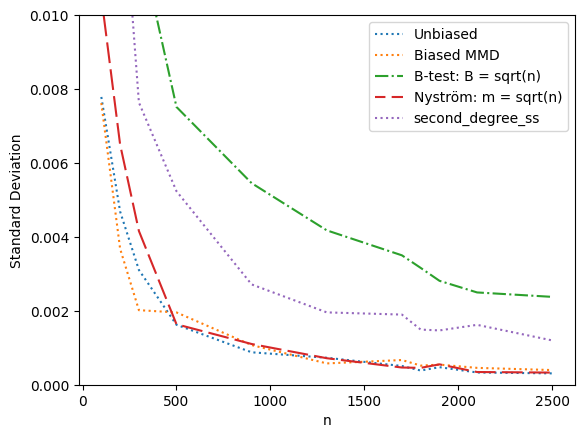

In [45]:
regular_scale = [100, 200, 300, 500, 900, 1300, 1700, 1800, 1900, 2100, 2500]
mmdaw_scale = [6, 7, 8, 9, 10, 11, 12]
iterations = 300

estimators = [
             (unbiased_mmd, None, regular_scale, "Unbiased", "dotted"),
             #(ltt, None, regular_scale, "Linear Time Test", "dashed"),
             (biased_mmd, None, regular_scale, "Biased MMD", "dotted"),
             (b_test, lambda x: np.sqrt(x), regular_scale, "B-test: B = sqrt(n)", "dashdot"),
             (nystroem_mmd, lambda x: np.sqrt(x), regular_scale, "Nyström: m = sqrt(n)", (5, (10, 3))),
             #(nystroem_mmd, lambda x: np.log(x), regular_scale, "Nyström: m = log(n)", (0, (3, 1, 1, 1, 1, 1))),
             
             #(run_mmdaw, None, mmdaw_scale, "MMDAW", "solid")
            ]



for (estimator, magnitude, scale, label, linestyle) in estimators:
    start = time.time()
    vs = []  
    for n_value in scale:
        variance = 0
        iter_vals = []
        for i in range(0, iterations):
            if estimator is run_mmdaw:
                variance += run_mmdaw(n_value)
                continue
            # X = np.random.randn(n_value, 1)
            # Y = np.random.randn(n_value, 1)
            X = np.random.normal(0, 1, n_value).reshape(-1,1)
            Y = np.random.normal(0, 1, n_value).reshape(-1,1)
            if magnitude is not None:
                iter_vals.append(estimator(X, Y, int(magnitude(n_value))))
            else:
                iter_vals.append(estimator(X, Y))
        vs.append(np.std(iter_vals))
    plt.plot(regular_scale, vs, label=label, linestyle=linestyle)
    plt.xlabel("n")
    plt.ylabel("Standard Deviation")
    end = time.time()
    print(f"{label}: took {end - start}s")
#add the second degree sampled nyström estimator
start = time.time()
vs = []  
for n_value in regular_scale:
    variance = 0
    iter_vals = []
    for i in range(0, iterations):
        # X = np.random.randn(n_value, 1)
        # Y = np.random.randn(n_value, 1)
        X = np.random.normal(0, 1, n_value).reshape(-1,1)
        Y = np.random.normal(0, 1, n_value).reshape(-1,1)
        first_degree_size = int(n_value / 2)
        X_1 = X[:first_degree_size]
        X_2 = X[first_degree_size:]
        Y_1 = Y[:first_degree_size]
        Y_2 = Y[first_degree_size:]
        X_1_ss, alpha_1 , x_midx_1 = get_subsample_and_weights(X_1)
        X_2_ss, alpha_2, x_midx_2 = get_subsample_and_weights(X_2)
        X_ss_merged, X_ss_merged_weights = get_merged_subsample_and_merged_weights(X_1_ss, X_2_ss, alpha_1, alpha_2, first_degree_size, first_degree_size)
        Y_1_ss, beta_1, y_midx_1  = get_subsample_and_weights(Y_1)
        Y_2_ss, beta_2, y_midx_2  = get_subsample_and_weights(Y_2)
        Y_ss_merged, Y_ss_merged_weights = get_merged_subsample_and_merged_weights(Y_1_ss, Y_2_ss, beta_1, beta_2, first_degree_size, first_degree_size)
        sec_deg_nystroem_value = nystroem_mmd_from_weights(X_ss_merged,Y_ss_merged, X_ss_merged_weights, Y_ss_merged_weights)
        iter_vals.append(sec_deg_nystroem_value)
    vs.append(np.std(iter_vals))
plt.plot(regular_scale, vs, label="second_degree_ss", linestyle="dotted")
plt.xlabel("n")
plt.ylabel("Standard Deviation")
end = time.time()
print(f"second_degree_ss took {end - start}s")
#
plt.ylim(0,.01)
plt.legend(loc="upper right")
plt.savefig('mmd-estimators_nys.pdf')
plt.show()    


We now try to find one of these cases where mmd deviates in extreme amounts:

In [16]:
def intersection(*arrays):
    result = np.intersect1d(arrays[0], arrays[1])
    for arr in arrays[2:]:
        result = np.intersect1d(result, arr)
    return result
def difference(array, *others):
    for other in others:
        array = np.setdiff1d(array, other)
    return array

In [17]:

sample_size = 500 
X = np.random.normal(0, 1, sample_size).reshape(-1,1)
Y = np.random.normal(0, 1, sample_size).reshape(-1,1)
first_degree_size = int(sample_size / 2)
X_1 = X[:first_degree_size]
X_2 = X[first_degree_size:]
Y_1 = Y[:first_degree_size]
Y_2 = Y[first_degree_size:]
X_1_ss, alpha_1 , x_midx_1 = get_subsample_and_weights(X_1)
X_2_ss, alpha_2 , x_midx_2 = get_subsample_and_weights(X_2)
X_ss_merged, X_ss_merged_weights = get_merged_subsample_and_merged_weights(X_1_ss, X_2_ss, alpha_1, alpha_2, first_degree_size, first_degree_size)
Y_1_ss, beta_1 , y_midx_1 = get_subsample_and_weights(Y_1)
Y_2_ss, beta_2 , y_midx_2 = get_subsample_and_weights(Y_2)
Y_ss_merged, Y_ss_merged_weights = get_merged_subsample_and_merged_weights(Y_1_ss, Y_2_ss, beta_1, beta_2, first_degree_size, first_degree_size)
sec_deg_nystroem_value = nystroem_mmd_from_weights(X_ss_merged,Y_ss_merged, X_ss_merged_weights, Y_ss_merged_weights)
print(len(X_ss_merged)-len(intersection(X_ss_merged, X)))
print(len(Y_ss_merged)-len(intersection(Y_ss_merged, Y)))
print(sec_deg_nystroem_value)
len(X_ss_merged)

7
3
0.00043925927669049506


22

### There exists another approach which makes use of random Fourier features (rff) to estimate MMD. In this section, we will investigate, whether this approach can outperform Nyström-estimators in terms of efficiency.

In [18]:
def sigma_from_gamma(gamma):
    return np.sqrt(2 * gamma)


def estimate_kernel(x, y, num_rff, gamma=1, seed=1234):
    rng = np.random.default_rng(seed=seed)
    w = rng.normal(scale=sigma_from_gamma(gamma), size=(num_rff,x.shape[1]))
    X_samples = x @ w.T 
    Y_samples = y @ w.T
    phi_x = 1 / np.sqrt(num_rff) * np.concatenate((np.cos(X_samples.T), np.sin(X_samples.T))).T
    phi_y = 1 / np.sqrt(num_rff) * np.concatenate((np.cos(Y_samples.T), np.sin(Y_samples.T))).T
    return phi_x @ phi_y.T


In [19]:


def get_Z(data, num_rff, gamma=1, seed=1234):
    rng = np.random.default_rng(seed=seed)
    w = rng.normal(scale=sigma_from_gamma(gamma),size=(num_rff,data.shape[1]))
    template = data @ w.T
    return  1 / np.sqrt(num_rff) * np.concatenate((np.cos(template.T),np.sin(template.T))).T

First, check how good the kernel approximation is:

In [20]:
x = np.random.randn(1, 5)
y = np.random.randn(1, 5)
print(estimate_kernel(x, y, num_rff=5000))
print(rbf_kernel(x, y,gamma=1))

[[-0.01791061]]
[[0.00595386]]


Next, the approximation of the Nyström-kernel-matrices is evaluated

In [21]:
n = 1000
num_rff = 1000
X = np.random.randn(n, 1)
Y = np.random.randn(n, 1)

m_idx = np.random.default_rng().integers(n, size=int(np.sqrt(n)))
X_tilde = X[m_idx]
Y_tilde = Y[m_idx]

XX = rbf_kernel(X_tilde, X_tilde)

Z_X = get_Z(data=X, num_rff=num_rff)
Z_XX = Z_X @ Z_X.T

Implement MMD using rffs:

In [22]:
def rff_mmd(X, Y, num_rff):    
    n = len(X)
    m = len(Y)
    
    Z_X = get_Z(data=X, num_rff=num_rff)
    Z_Y = get_Z(data=Y, num_rff=num_rff)
    
    return 1 / (n ** 2) * np.ones((n, 1)).T @ Z_X @ Z_X.T @ np.ones((n, 1)) + 1 / (m ** 2) * np.ones((m, 1)).T @ Z_Y @ Z_Y.T @ np.ones((m, 1)) - 2 / (n * m) * np.ones((n, 1)).T @ Z_X @ Z_Y.T @ np.ones((m, 1))

#### Nyström-MMD (square-root) vs rff-MMD

In [23]:
n = 10000
X = np.random.randn(n, 1)
Y = np.random.randn(n, 1)

start = time.time()
nystroem_result = nystroem_mmd(X, Y, m=int(np.sqrt(n)))
end = time.time()
nystroem_runtime = end - start

start = time.time()
rff_result = rff_mmd(X, Y, num_rff=10)[0][0]
end = time.time()
rff_runtime = end - start

print(f"Nyström: {nystroem_result}, runtime: {nystroem_runtime}s")
print(f"rff: {rff_result}, runtime: {rff_runtime}s")

Nyström: 0.00010968713679204711, runtime: 0.04478192329406738s
rff: 0.0001318944525935395, runtime: 0.007776975631713867s


Robustness-tests:

In [24]:
n = 10000
X = np.random.randn(n, 1)
n_binom, p = 5, 0.4
Y = np.random.binomial(n=n_binom, p=p, size=(n, 1))
#Y = np.random.chisquare(df=2, size=(n, 1))

start = time.time()
nystroem_result = nystroem_mmd(X, Y, m=int(np.sqrt(n)))
end = time.time()
nystroem_runtime = end - start

start = time.time()
rff_result = rff_mmd(X, Y, num_rff=1000)[0][0]
end = time.time()
rff_runtime = end - start

print(f"Nyström: {nystroem_result}, runtime: {nystroem_runtime}s")
print(f"rff: {rff_result}, runtime: {rff_runtime}s")

Nyström: 0.4248869590705078, runtime: 0.03383207321166992s
rff: 0.4101429416310723, runtime: 0.7624189853668213s


#### Biased MMD vs streaming rff-MMD 

In [25]:
def phi_hat(x, s):
    rng = np.random.default_rng(seed=1234)
    w = rng.normal(scale=sigma_from_gamma(gamma=1), size=s)
    wx = w.T * x
    return 1 / np.sqrt(s) * np.concatenate((np.cos(wx), np.sin(wx)))


def streaming_rff_mmd(X, Y, num_rff):
    n = len(X)
    
    X_total = np.zeros(2 * num_rff)
    Y_total = np.zeros(2 * num_rff)
    for x, y in zip(X, Y):
        X_total += phi_hat(x, num_rff)
        Y_total += phi_hat(y, num_rff)
    
    return 1 / (n ** 2) * np.linalg.norm(X_total - Y_total) ** 2
    
    #return 1 / (len(Z_X) * len(Z_Y)) * np.linalg.norm(sum(Z_X) - sum(Z_Y))

In [26]:
n = 1000
X = np.random.randn(n, 1)
Y = np.random.randn(n, 1)
streaming_rff_mmd(X, Y, 100)

0.0050140240004249576

In [27]:
n = 12000
X = np.random.randn(n, 1)
Y = np.random.randn(n, 1)
#n_binom, p = 5, 0.4
#Y = np.random.binomial(n=n_binom, p=p, size=(n, 1))
#Y = np.random.chisquare(df=2, size=(n, 1))

start = time.time()
biased_result = biased_mmd(X, Y)
end = time.time()
biased_runtime = end - start

start = time.time()
streaming_rff_result = streaming_rff_mmd(X, Y, num_rff=500)
end = time.time()
streaming_rff_runtime = end - start

print(f"Biased: {biased_result}, runtime: {biased_runtime}s")
print(f"rff: {streaming_rff_result}, runtime: {streaming_rff_runtime}s")

Biased: 0.0001426581798571469, runtime: 3.7507572174072266s
rff: 0.00015390350257180654, runtime: 0.7796142101287842s
